**케라스를 사용한 인공 신경망**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

# 깔끔한 그래프 출력을 위해
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{fig_extension}")
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 퍼셉트론

In [2]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris.target == 0).astype(int)
per_clf = Perceptron(n_jobs=-1)
per_clf.fit(X, y)
y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([0])

그림 저장: perceptron_iris_plot


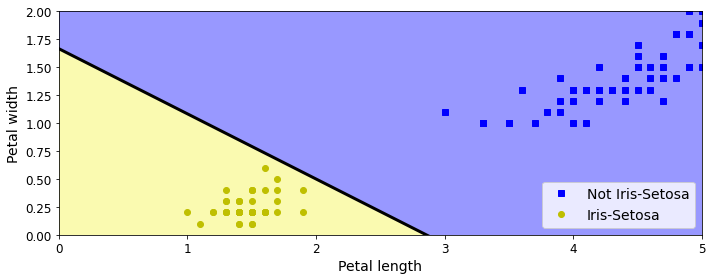

In [4]:
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1), np.linspace(axes[2], axes[3], 200).reshape(-1, 1)
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
plt.figure(figsize=(10, 4))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris-Setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
custom_cmap = ListedColormap(["#9898ff", "#fafab0"])
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)
save_fig("perceptron_iris_plot")
plt.show()

# 활성화 함수

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def relu(z):
    return np.maximum(0, z)


def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

그림 저장: activation_functions_plot


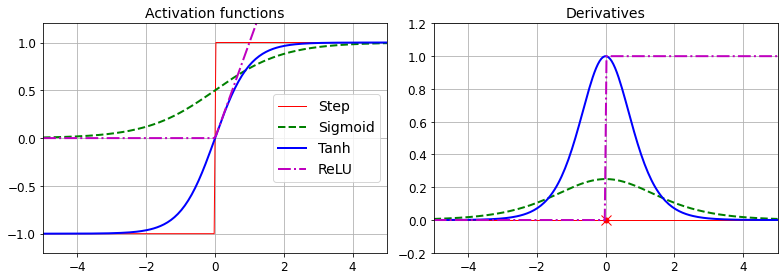

In [6]:
z = np.linspace(-5, 5, 200)
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])
plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
save_fig("activation_functions_plot")
plt.show()

In [7]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)


def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

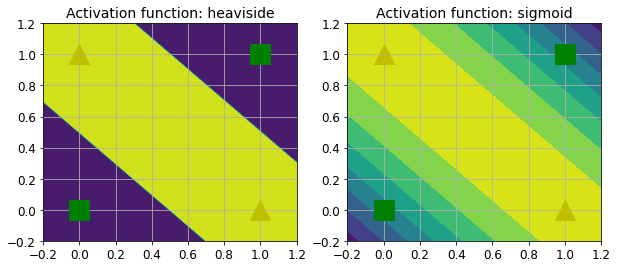

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)
z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)
plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# 이미지 분류기 만들기

먼저 텐서플로와 케라스를 임포트한다.

In [9]:
import tensorflow as tf

tf.__version__

'2.10.0'

In [10]:
from tensorflow import keras

keras.__version__

'2.10.0'

먼저 MNIST 데이터셋을 로드한다. 케라스는 `keras.datasets`에 널리 사용하는 데이터셋을 로드하기 위한 함수를 제공한다. 이 데이터셋은 이미 훈련 세트와 테스트 세트로 나누어져 있다. 훈련 세트를 더 나누어 검증 세트를 만드는 것이 좋다:

In [11]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

훈련 세트는 60,000개의 흑백 이미지이다. 각 이미지의 크기는 28x28 픽셀이다:

In [12]:
X_train_full.shape

(60000, 28, 28)

각 픽셀의 강도는 바이트(0~255)로 표현된다:

In [13]:
X_train_full.dtype

dtype('uint8')

전체 훈련 세트를 검증 세트와 (조금 더 작은) 훈련 세트로 나눈다. 또한 픽셀 강도를 255로 나누어 0~1 범위의 실수로 바꾼다.

In [14]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

맷플롯립의 `imshow()` 함수와 `'binary'` 컬러맵을 사용해 이미지를 출력한다:

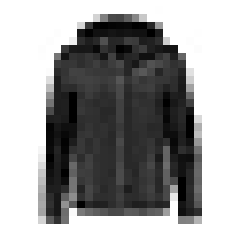

In [15]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

레이블은 0에서 9까지 (uint8로 표현된) 클래스 아이디이다:

In [16]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

클래스 이름은 다음과 같다:

In [17]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

훈련 세트에 있는 첫 번째 이미지는 코트이다:

In [18]:
class_names[y_train[0]]

'Coat'

검증 세트는 5,000개의 이미지를 담고 있고 테스트 세트는 10,000개의 이미지를 가진다:

In [19]:
X_valid.shape

(5000, 28, 28)

In [20]:
X_test.shape

(10000, 28, 28)

이 데이터셋에 있는 샘플 이미지를 몇 개 출력해 본다:

그림 저장: fashion_mnist_plot


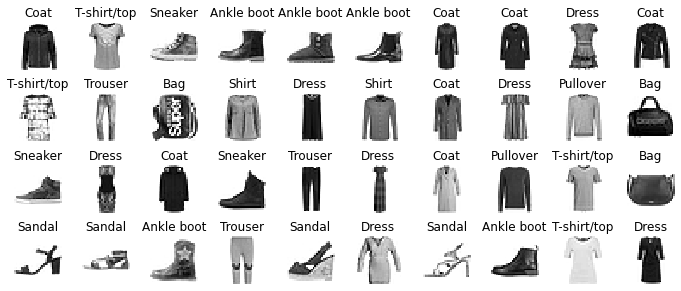

In [21]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig("fashion_mnist_plot", tight_layout=False)
plt.show()

In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [23]:
keras.backend.clear_session()

In [24]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [25]:
model.layers

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


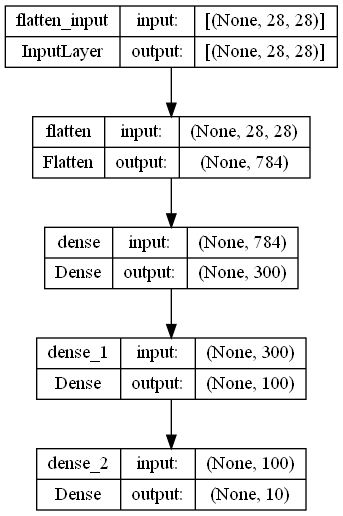

In [27]:
keras.utils.plot_model(model, os.path.join(IMAGES_PATH, "my_fashion_mnist_model.png"), show_shapes=True)

In [28]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [29]:
model.get_layer(hidden1.name) is hidden1

True

In [30]:
weights, biases = hidden1.get_weights()

In [31]:
weights

array([[ 0.06816891,  0.04433557,  0.03078763, ...,  0.04793689,
         0.01760455,  0.05835992],
       [-0.02845773, -0.03280742, -0.07251776, ..., -0.07142695,
         0.06497598, -0.03378846],
       [-0.0504798 ,  0.05103099,  0.05711536, ..., -0.01175164,
        -0.05316329, -0.06803521],
       ...,
       [ 0.04167432,  0.0312061 , -0.06391165, ...,  0.06184669,
         0.0594362 ,  0.05761413],
       [-0.03457546, -0.02785607, -0.03959309, ..., -0.0191909 ,
        -0.06452859,  0.01077253],
       [-0.04676007, -0.0355794 ,  0.00766788, ..., -0.0334259 ,
        -0.05027603, -0.06456767]], dtype=float32)

In [32]:
weights.shape

(784, 300)

In [33]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [34]:
biases.shape

(300,)

In [35]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

위 코드는 다음과 같다:

```python
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.SGD(),
    metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [36]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
430/430 [==============================] - 3s 4ms/step - loss: 1.1420 - accuracy: 0.6518 - val_loss: 0.7386 - val_accuracy: 0.7610
Epoch 2/30
430/430 [==============================] - 2s 4ms/step - loss: 0.6679 - accuracy: 0.7787 - val_loss: 0.6031 - val_accuracy: 0.7964
Epoch 3/30
430/430 [==============================] - 2s 4ms/step - loss: 0.5740 - accuracy: 0.8089 - val_loss: 0.5505 - val_accuracy: 0.8176
Epoch 4/30
430/430 [==============================] - 2s 4ms/step - loss: 0.5282 - accuracy: 0.8203 - val_loss: 0.5122 - val_accuracy: 0.8244
Epoch 5/30
430/430 [==============================] - 2s 4ms/step - loss: 0.4985 - accuracy: 0.8315 - val_loss: 0.4918 - val_accuracy: 0.8346
Epoch 6/30
430/430 [==============================] - 2s 4ms/step - loss: 0.4767 - accuracy: 0.8352 - val_loss: 0.4777 - val_accuracy: 0.8390
Epoch 7/30
430/430 [==============================] - 2s 4ms/step - loss: 0.4592 - accuracy: 0.8418 - val_loss: 0.4757 - val_accuracy: 0.8382
Epoch 

In [37]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 430}

In [38]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

그림 저장: keras_learning_curves_plot


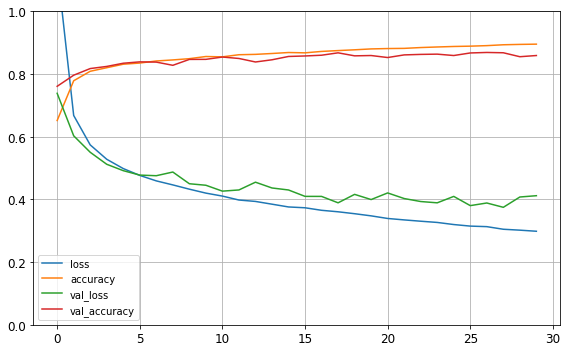

In [40]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [41]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4531 - accuracy: 0.8463


[0.45308154821395874, 0.8463000059127808]

In [42]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 80ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.09, 0.  , 0.85],
       [0.  , 0.  , 0.98, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [43]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 19ms/step


array([9, 2, 1], dtype=int64)

In [44]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [45]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

그림 저장: fashion_mnist_images_plot


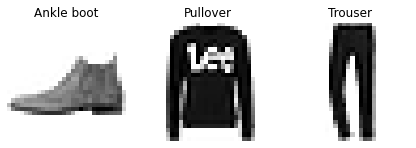

In [46]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis("off")
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig("fashion_mnist_images_plot", tight_layout=False)
plt.show()

# 회귀 MLP

캘리포니아 주택 데이터셋을 로드하여 나누고 스케일을 바꾸어 본다:

In [47]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [48]:
model = keras.models.Sequential(
    [keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]), keras.layers.Dense(1)]
)
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 3ms/step - loss: 2.1366 - val_loss: 0.8541
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.8048 - val_loss: 0.7443
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7387 - val_loss: 0.7053
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7010 - val_loss: 0.6727
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6705 - val_loss: 0.6432
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6430 - val_loss: 0.6186
Epoch 7/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6196 - val_loss: 0.5978
Epoch 8/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5997 - val_loss: 0.5792
Epoch 9/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5820 - val_loss: 0.5634
Epoch 10/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5671 - val_loss: 0.5505

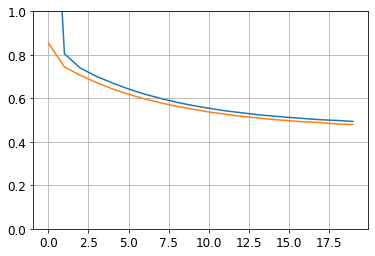

In [49]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [50]:
y_pred

array([[3.0183198],
       [0.8851979],
       [2.625247 ]], dtype=float32)

# 함수형 API

모든 신경망 모델이 단순하게 순서대로 나열되지는 않는다. 어떤 신경망은 매우 복잡한 구조를 가진다. 여러 개의 입력이 있거나 여러 개의 출력이 있다. 예를 들어 와이드 & 딥 신경망([논문](https://ai.google/research/pubs/pub45413) 참조)은 입력의 전체 또는 일부를 출력층에 바로 연결한다.

In [51]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [52]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 30)           930         ['dense_5[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_6[0][0]']            

In [53]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 2.0869 - val_loss: 0.8563
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7442 - val_loss: 0.6664
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6724 - val_loss: 0.6351
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6401 - val_loss: 0.6083
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6164 - val_loss: 0.5867
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5950 - val_loss: 0.5753
Epoch 7/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5871 - val_loss: 0.5581
Epoch 8/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5668 - val_loss: 0.5521
Epoch 9/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5570 - val_loss: 0.5335
Epoch 10/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5451 - val_loss: 0.5290

In [54]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [55]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]
history = model.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 2.2730 - val_loss: 0.9022
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7924 - val_loss: 0.7154
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6972 - val_loss: 0.6576
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6571 - val_loss: 0.6245
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6317 - val_loss: 0.6016
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6121 - val_loss: 0.5832
Epoch 7/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5953 - val_loss: 0.5665
Epoch 8/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5805 - val_loss: 0.5518
Epoch 9/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5675 - val_loss: 0.5402
Epoch 10/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5556 - val_loss: 0.5301

규제를 위한 보조 출력 추가하기:

In [56]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [57]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [58]:
history = model.fit(
    [X_train_A, X_train_B], [y_train, y_train], epochs=20, validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid])
)

Epoch 1/20
363/363 [==============================] - 2s 6ms/step - loss: 3.0787 - main_output_loss: 2.7720 - aux_output_loss: 5.8388 - val_loss: 1.5592 - val_main_output_loss: 1.2469 - val_aux_output_loss: 4.3698
Epoch 2/20
363/363 [==============================] - 2s 5ms/step - loss: 1.1610 - main_output_loss: 0.9129 - aux_output_loss: 3.3937 - val_loss: 0.9537 - val_main_output_loss: 0.7664 - val_aux_output_loss: 2.6395
Epoch 3/20
363/363 [==============================] - 2s 5ms/step - loss: 0.8780 - main_output_loss: 0.7289 - aux_output_loss: 2.2196 - val_loss: 0.8070 - val_main_output_loss: 0.6816 - val_aux_output_loss: 1.9364
Epoch 4/20
363/363 [==============================] - 2s 6ms/step - loss: 0.7792 - main_output_loss: 0.6737 - aux_output_loss: 1.7290 - val_loss: 0.7404 - val_main_output_loss: 0.6410 - val_aux_output_loss: 1.6351
Epoch 5/20
363/363 [==============================] - 2s 6ms/step - loss: 0.7297 - main_output_loss: 0.6423 - aux_output_loss: 1.5162 - val_loss

In [59]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

1/1 [==============================] - 0s 64ms/step


# 서브클래싱 API

In [60]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output


model = WideAndDeepModel(30, activation="relu")

In [61]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(
    (X_train_A, X_train_B), (y_train, y_train), epochs=10, validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid))
)
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 4s 9ms/step - loss: 2.7980 - output_1_loss: 2.3626 - output_2_loss: 6.7166 - val_loss: 1.5731 - val_output_1_loss: 1.0998 - val_output_2_loss: 5.8326
Epoch 2/10
363/363 [==============================] - 3s 8ms/step - loss: 1.3447 - output_1_loss: 0.9349 - output_2_loss: 5.0328 - val_loss: 1.0922 - val_output_1_loss: 0.7517 - val_output_2_loss: 4.1572
Epoch 3/10
363/363 [==============================] - 2s 6ms/step - loss: 1.0047 - output_1_loss: 0.7171 - output_2_loss: 3.5927 - val_loss: 0.9011 - val_output_1_loss: 0.6668 - val_output_2_loss: 3.0098
Epoch 4/10
363/363 [==============================] - 2s 6ms/step - loss: 0.8646 - output_1_loss: 0.6636 - output_2_loss: 2.6736 - val_loss: 0.7984 - val_output_1_loss: 0.6299 - val_output_2_loss: 2.3144
Epoch 5/10
363/363 [==============================] - 2s 6ms/step - loss: 0.7829 - output_1_loss: 0.6348 - output_2_loss: 2.1161 - val_loss: 0.7341 - val_output_1_loss: 0.6046 - val_ou

# 저장과 복원

In [62]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(30, activation="relu", input_shape=[8]),
        keras.layers.Dense(30, activation="relu"),
        keras.layers.Dense(1)
    ]
)

In [63]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 2.0696 - val_loss: 0.8350
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.8012 - val_loss: 0.7385
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.7341 - val_loss: 0.6943
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6925 - val_loss: 0.6585
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6577 - val_loss: 0.6297
Epoch 6/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6284 - val_loss: 0.6041
Epoch 7/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6031 - val_loss: 0.5811
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5808 - val_loss: 0.5622
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5612 - val_loss: 0.5450
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.5094


In [64]:
model.save("my_keras_model.h5")

In [65]:
model = keras.models.load_model("my_keras_model.h5")

In [66]:
model.predict(X_new)

1/1 [==============================] - 0s 47ms/step


array([[2.9359622],
       [1.2156653],
       [2.6134818]], dtype=float32)

In [67]:
model.save_weights("my_keras_weights.ckpt")

In [68]:
model.load_weights("my_keras_weights.ckpt")

# 훈련 과정에서 콜백 사용하기

In [69]:
keras.backend.clear_session()

In [70]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(30, activation="relu", input_shape=[8]),
        keras.layers.Dense(30, activation="relu"),
        keras.layers.Dense(1)
    ]
)

In [71]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5")  # 최상의 모델로 롤백
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 2s 4ms/step - loss: 1.9327 - val_loss: 0.8855
Epoch 2/10
363/363 [==============================] - 1s 4ms/step - loss: 0.9025 - val_loss: 0.7063
Epoch 3/10
363/363 [==============================] - 1s 4ms/step - loss: 0.7017 - val_loss: 0.6591
Epoch 4/10
363/363 [==============================] - 1s 4ms/step - loss: 0.6583 - val_loss: 0.6230
Epoch 5/10
363/363 [==============================] - 1s 4ms/step - loss: 0.6245 - val_loss: 0.5931
Epoch 6/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5957 - val_loss: 0.5666
Epoch 7/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5715 - val_loss: 0.5447
Epoch 8/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5506 - val_loss: 0.5268
Epoch 9/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5337 - val_loss: 0.5101
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.4821


In [74]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb]
)
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
121/121 [==============================] - 1s 6ms/step - loss: 0.3797 - val_loss: 0.3414
Epoch 2/100
121/121 [==============================] - 1s 5ms/step - loss: 0.3748 - val_loss: 0.3427
Epoch 3/100
121/121 [==============================] - 1s 4ms/step - loss: 0.3740 - val_loss: 0.3417
Epoch 4/100
121/121 [==============================] - 1s 4ms/step - loss: 0.3733 - val_loss: 0.3418
Epoch 5/100
121/121 [==============================] - 1s 5ms/step - loss: 0.3733 - val_loss: 0.3413
Epoch 6/100
121/121 [==============================] - 1s 4ms/step - loss: 0.3726 - val_loss: 0.3413
Epoch 7/100
121/121 [==============================] - 1s 4ms/step - loss: 0.3721 - val_loss: 0.3410
Epoch 8/100
121/121 [==============================] - 1s 4ms/step - loss: 0.3720 - val_loss: 0.3401
Epoch 9/100
121/121 [==============================] - 1s 4ms/step - loss: 0.3711 - val_loss: 0.3399
Epoch 10/100
121/121 [==============================] - 1s 4ms/step - loss: 0.3708 - val_lo

In [88]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: ", round(logs["val_loss"] / logs["loss"], 2))

In [89]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[val_train_ratio_cb])

361/363 [============================>.] - ETA: 0s - loss: 0.3566
val/train:  0.93
363/363 [==============================] - 1s 3ms/step - loss: 0.3565 - val_loss: 0.3319


# 텐서보드

In [90]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [92]:
import time


def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)


run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2022_09_25-15_47_00'

In [93]:
keras.backend.clear_session()

In [94]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(30, activation="relu", input_shape=[8]),
        keras.layers.Dense(30, activation="relu"),
        keras.layers.Dense(1)
    ]
)
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [95]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(
    X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, tensorboard_cb]
)

Epoch 1/30
363/363 [==============================] - 2s 4ms/step - loss: 1.7499 - val_loss: 0.8619
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 0.7925 - val_loss: 0.7247
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 0.7076 - val_loss: 0.6707
Epoch 4/30
363/363 [==============================] - 1s 4ms/step - loss: 0.6631 - val_loss: 0.6353
Epoch 5/30
363/363 [==============================] - 1s 3ms/step - loss: 0.6310 - val_loss: 0.6066
Epoch 6/30
363/363 [==============================] - 1s 3ms/step - loss: 0.6043 - val_loss: 0.5813
Epoch 7/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5813 - val_loss: 0.5599
Epoch 8/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5602 - val_loss: 0.5409
Epoch 9/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5428 - val_loss: 0.5241
Epoch 10/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5277 - val_loss: 0.5105

텐서보드 서버를 실행하는 한 가지 방법은 터미널에서 직접 실행하는 것이다. 터미널을 열고 텐서보드가 설치된 가상 환경을 활성화한다. 그다음 노트북 디렉토리로 이동하여 다음 명령을 입력한다:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

그다음 웹 브라우저를 열고 [localhost:6006](http://localhost:6006)에 접속하면 텐서보드를 사용할 수 있다. 사용이 끝나면 터미널에서 Ctrl-C를 눌러 텐서보드 서버를 종료한다.

또는 다음처럼 텐서보드의 주피터 확장을 사용할 수 있다(이 명령은 텐서보드가 로컬 컴퓨터에 설치되어 있어야 한다):

```python
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006
```

In [102]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2022_09_25-15_57_02'

In [103]:
keras.backend.clear_session()

In [104]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(30, activation="relu", input_shape=[8]),
        keras.layers.Dense(30, activation="relu"),
        keras.layers.Dense(1)
    ]
)
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [105]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(
    X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, tensorboard_cb]
)

Epoch 1/30
363/363 [==============================] - 2s 4ms/step - loss: 0.6293 - val_loss: 0.7531
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 1.0448 - val_loss: 0.4016
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 0.4131 - val_loss: 0.3875
Epoch 4/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3830 - val_loss: 0.3663
Epoch 5/30
363/363 [==============================] - 1s 4ms/step - loss: 0.3696 - val_loss: 0.3462
Epoch 6/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3622 - val_loss: 0.3823
Epoch 7/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3532 - val_loss: 0.3223
Epoch 8/30
363/363 [==============================] - 1s 4ms/step - loss: 0.3448 - val_loss: 0.3199
Epoch 9/30
363/363 [==============================] - 1s 4ms/step - loss: 0.4865 - val_loss: 0.3883
Epoch 10/30
363/363 [==============================] - 1s 4ms/step - loss: 0.3893 - val_loss: 0.3376

텐서보드에 실행 결과가 2개 있다. 학습 곡선을 비교해 본다.

사용할 수 있는 로깅 옵션을 확인해 본다:

In [106]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=0, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.

